# Kernel functions for Gaussian Processes
Overview of different kernel functions for Gaussian process modelling of continuous variables.
For general kernel design considerations see e.g. https://www.cs.toronto.edu/~duvenaud/cookbook/ and http://ml.dcs.shef.ac.uk/gpss/gpws14/KernelDesign.pdf.    

For **stationary kernels** the covariance between two points only depends on the distance between them, $r = |x - x'| / L$ (l2-norm), where $L$ is the lengthscale.
The lengthscale may be chosen / estimated individually for each dimension, which runs under the term "automatic relevance determination" (ARD).
The variance $\sigma^2$ specifies the magnitude of the difference in the response value between two points.  

Conversely, **non-stationary** kernels, such as the linear and polynomial kernel, depend on the absolute positions $x,\,x'$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import GPy

In [2]:
def plot_kernel(kernel):
    X = np.linspace(-4, 4, 201)
    K_xx = kernel.K(X.reshape(201, 1))
    prior_samples  = np.random.multivariate_normal(np.zeros_like(X), K_xx, 3).T
    X_data = np.array([-2.5, 3])[:, np.newaxis]
    Y_data = np.array([-0.5, 2])[:, np.newaxis]
    gp = GPy.models.GPRegression(X_data, Y_data, kernel=kernel, noise_var=0.05)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 5))
    ax1.plot(X, K_xx[125])
    pc = ax2.pcolor(X, X, K_xx)
    
    # hacky solution to place colorbar inside plot
    cbaxes = inset_axes(ax2, width="50%", height="5%", loc='upper right') 
    cbar = plt.colorbar(pc, cax=cbaxes, orientation='horizontal')
    plt.setp(plt.getp(cbaxes, 'xticklabels'), color='w')  # set xticklabels color
    cbaxes.xaxis.set_tick_params(color='w')  # set colorbar ticks color 
    ax2.invert_yaxis()
    
    ax3.plot(X, prior_samples)
    gp.plot_data(ax=ax4)
    gp.plot_confidence(ax=ax4)
    gp.plot_mean(ax=ax4)
    gp.plot_samples(ax=ax4)
    ax4.get_legend().remove()
    ax1.set(title="Kernel $k(x, 1)$", xlabel='$x$', ylabel='$k(x,{})$'.format(X[125]), xlim=(-4, 4))
    ax2.set(title="Kernel $k(x, x')$", xlabel='$x$', ylabel="$x'$", xlim=(-4, 4))
    ax3.set(title="Prior samples", xlabel='$x$', ylabel='$f(x)$', xlim=(-4, 4))
    ax4.set(title="Posterior distribution and samples", xlabel='$x$', ylabel='$f(x)$', xlim=(-4, 4))

## Matern kernels
$k(r) = \left(\sqrt{2 \nu} r \right)^{\nu} K_{\nu}\left( \sqrt{2 \nu} r \right) / \left( \Gamma(\nu)2^{\nu-1} \right)$  
where where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. 
The class of Matern kernels is a generalization of the RBF and the absolute exponential kernel, parameterized by an additional parameter $\nu$.
The smaller $\nu$, the less smooth the approximated function is. When $\nu = p + \frac12$, realizations are $p$-times differentiable. 
For $\nu=\infty$, the RBF kernel (infinitely differentiable) and for $\nu=1/2$ to the absolute exponential kernel (not differentiable) are obtained. Often used intermediate values are $\nu=3/2$ and $\nu=5/2$, giving once and twice differentiable functions.

### (Absolute) Exponential kernel
$k(r) = \exp(-r)$

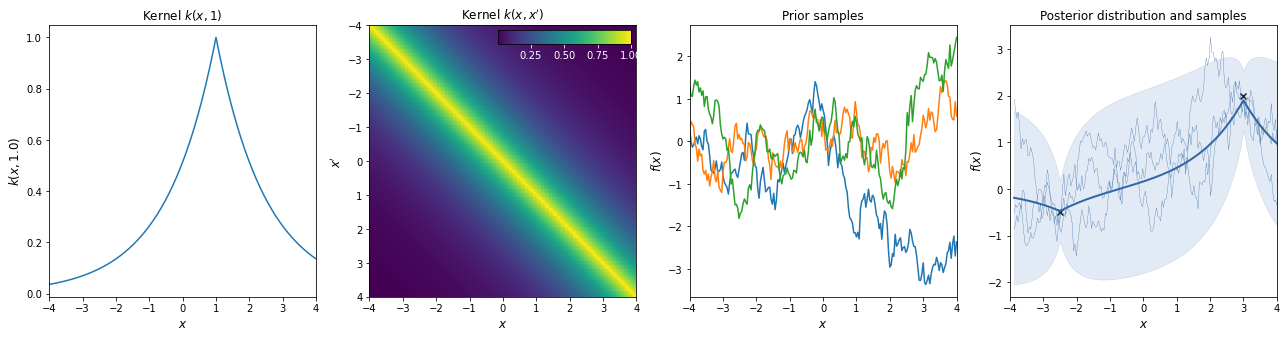

In [3]:
k = GPy.kern.Exponential(1, lengthscale=1.5)
plot_kernel(k)

### Matern 3/2 kernel
$k(r) = (1+r) \exp(-r)$

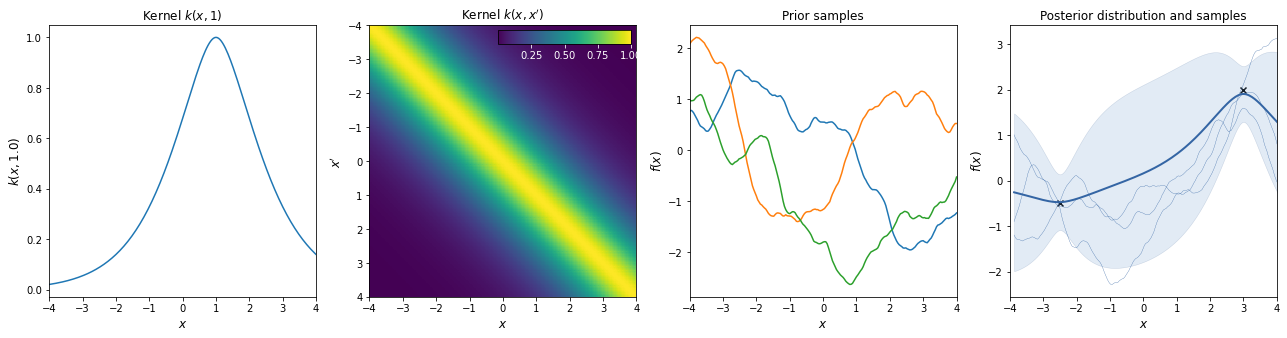

In [4]:
k = GPy.kern.Matern32(1, lengthscale=1.5)
plot_kernel(k)

### Matern 5/2 kernel
$k(r) = \sigma^2 \left( 1 + \sqrt{5} r + \frac53 r^2 \right) \exp \left( -\sqrt{5} r \right)$

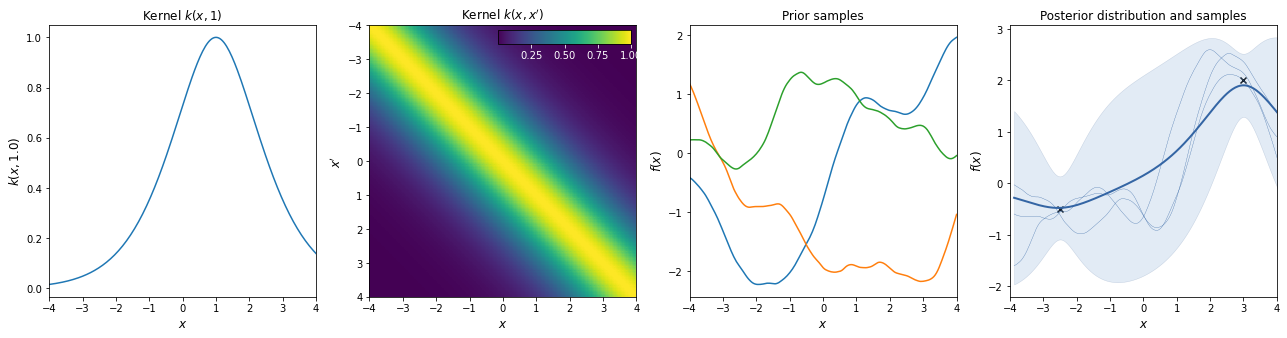

In [5]:
k = GPy.kern.Matern52(1, lengthscale=1.5)
plot_kernel(k)

### Squared exponential kernel / Gaussian kernel / Radial Basis Function
$k(r) = \exp(-r^2/2)$

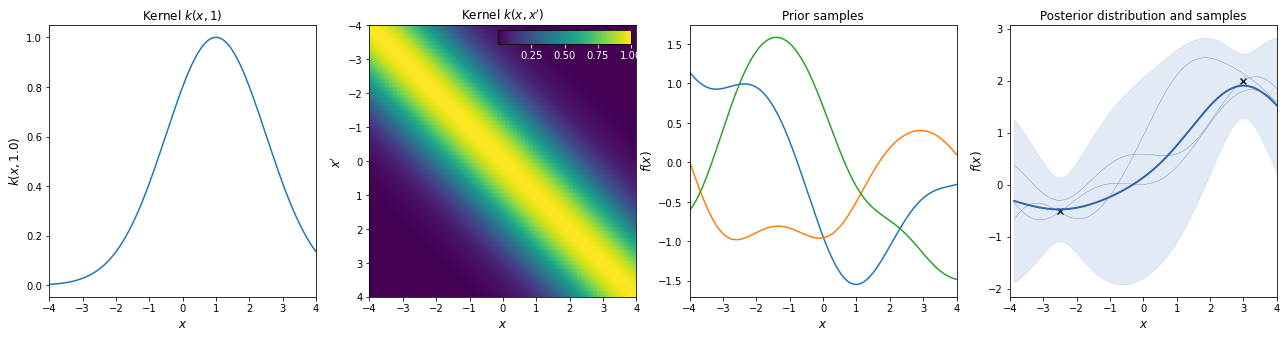

In [6]:
k = GPy.kern.RBF(1, lengthscale=1.5)
plot_kernel(k)

### Rational quadratic kernel
$k(r) = \left( 1 + \frac{r^2}{2} \right)^{- \alpha}$  
This kernel is equivalent to adding together many RBF kernels with different lengthscales. So, GP priors with this kernel expect to see functions which vary smoothly across many lengthscales. The parameter α determines the relative weighting of large-scale and small-scale variations. When $\alpha \rightarrow \infty$, the RQ is identical to the RBF.

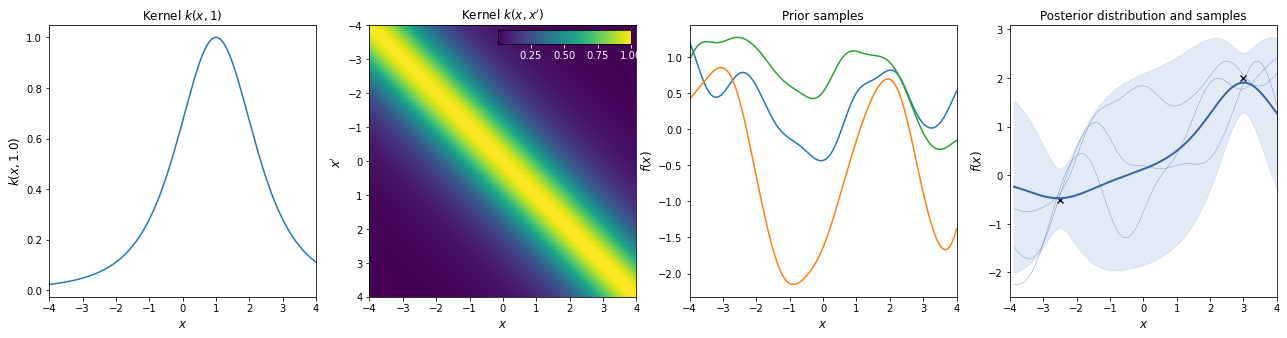

In [7]:
k = GPy.kern.RatQuad(1, lengthscale=1.5)
plot_kernel(k)

### White noise kernel
$k(r) = \delta_r$  
Additive noise. *Note*: The GP models in GPy contain a white noise term already, so this is not needed in most cases.

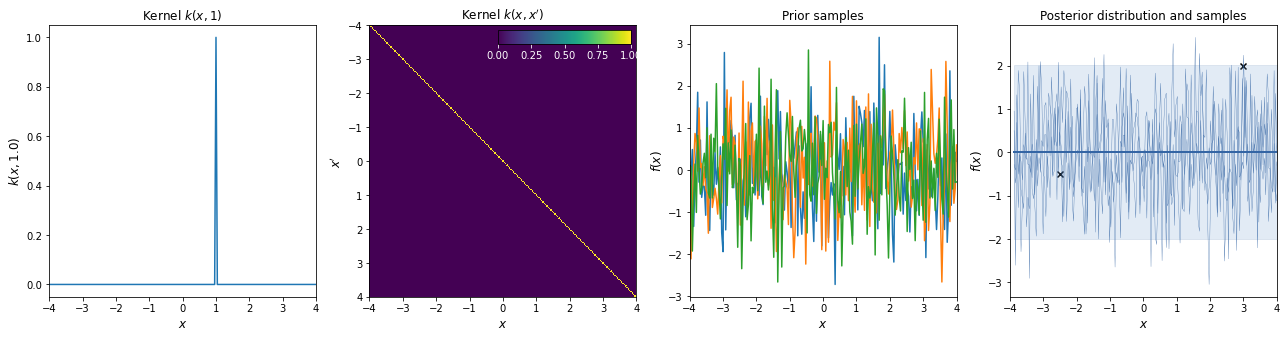

In [8]:
k = GPy.kern.White(1)
plot_kernel(k)

## Non-statinonary kernels

### Brownian kernel
$k(x,x') = \min(x,x')$  
*Note*: In GPy negative times are treated as a separate (backwards!) Brownian motion.  
$k(x,x') = \begin{cases} \min(x,x') \quad x > 0,\, x' > 0 \\ \min(|x|,|x'|) \quad x < 0,\, x' < 0\\0 \quad \mathrm{else} \end{cases}$

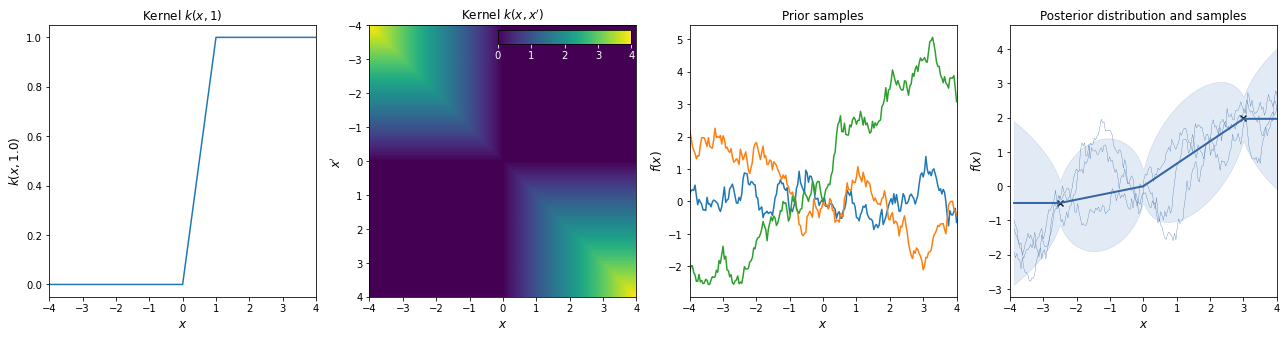

In [9]:
k = GPy.kern.Brownian(1)
plot_kernel(k)

### Dot-product / linear kernel
$k(x,x') = a\, x^T \cdot x'$  
This kernel is non-stationary and can be obtained from linear regression by putting $N(\mu=0, \sigma=a)$ priors on the coefficients of $x$.

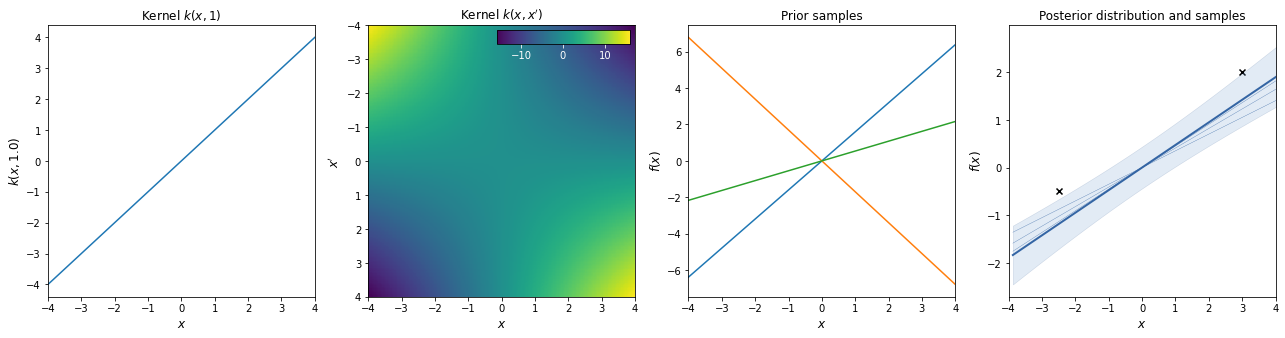

In [10]:
k = GPy.kern.Linear(1, variances=1)
plot_kernel(k)

### Bias kernel
$k(x,x') = b$  
*Note*: Stationary kernels allow model any bias (constant offset) simply via the support that is provided by the data. However non-stationary kernels require an additive bias kernel in that case.

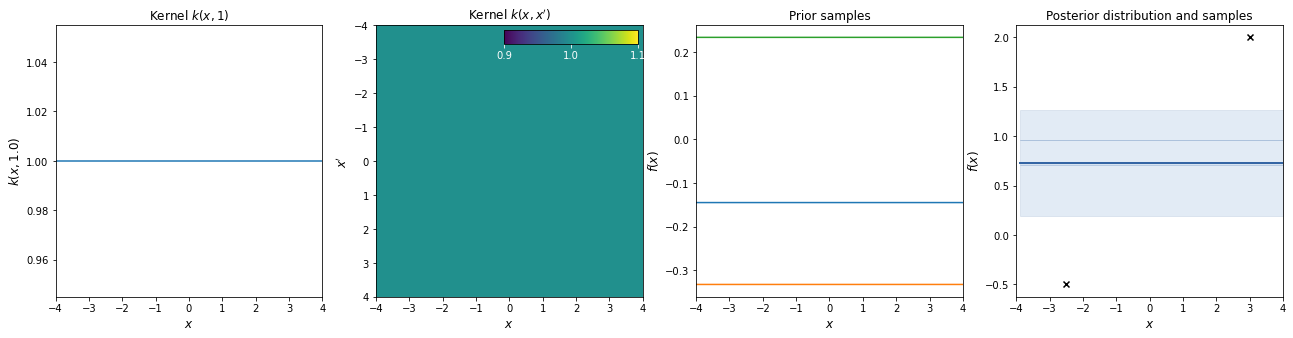

In [11]:
k = GPy.kern.Bias(1)
plot_kernel(k)

### Linear + bias = affine kernel
$k(x,x') = a\, x^T \cdot x' + b$  

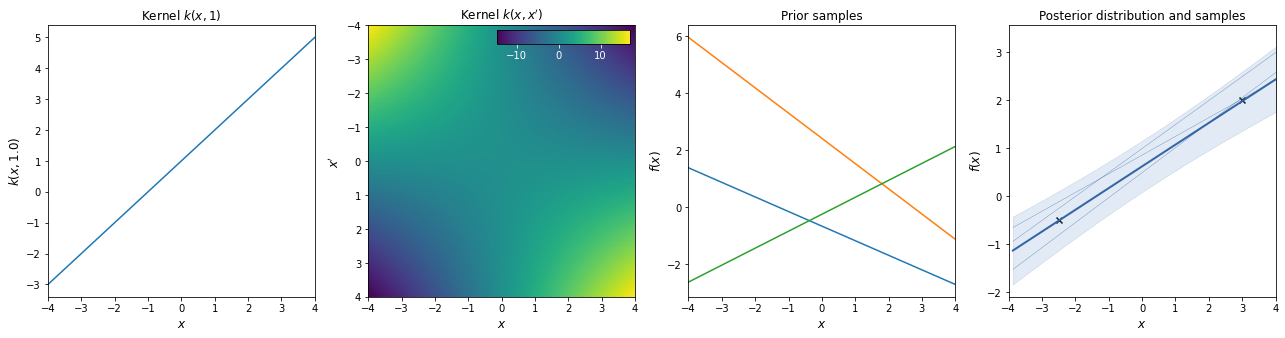

In [12]:
k = GPy.kern.Linear(1) + GPy.kern.Bias(1)
plot_kernel(k)

### Polynomial kernel
$k(x,x') = (a \, x^T \cdot x' + b)^d$  
The polynomial kernel can be obtained by exponentiation of an affine kernel, with `scale` a, `bias` $b$, and `order` $d$.

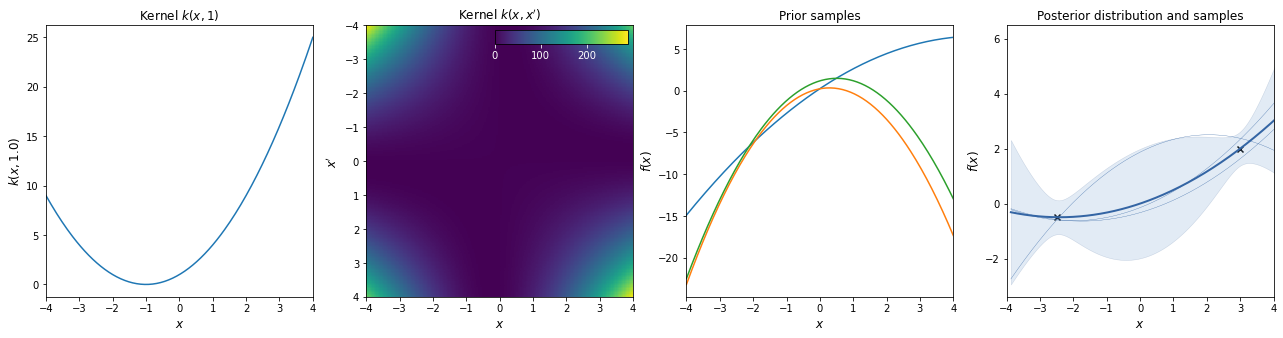

In [13]:
k = GPy.kern.Poly(1, scale=1, bias=1, order=2)
plot_kernel(k)

## Periodic kernels

### Cosine
$k(r) = ?$

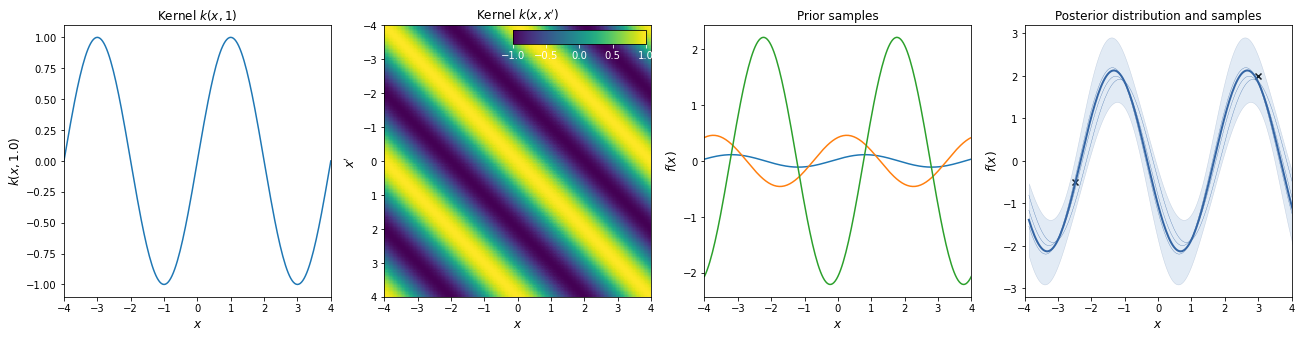

In [14]:
k = GPy.kern.Cosine(1, lengthscale=4/(2*np.pi))
plot_kernel(k)

### Standard periodic kernel
$k(r) = \exp \left( - \frac{\sin^2( \pi r/T )}{2L^2}  \right) \quad r = |x-x'|$  
The periodic kernel (derived by David Mackay) allows one to model functions which repeat themselves exactly. Its parameters are easily interpretable: 
* The period $T$ simply determines the distance between repititions of the function.
* The lengthscale $L$ determines the lengthscale function in the same way as in the RBF kernel.

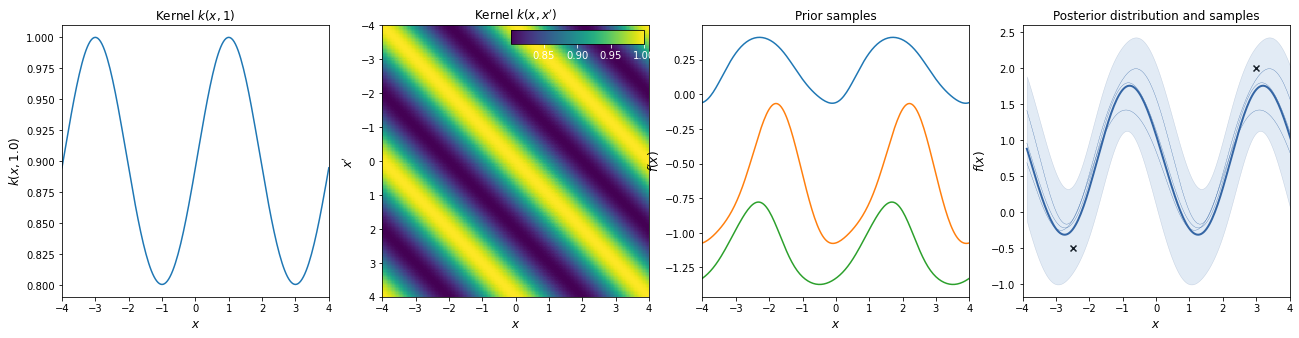

In [15]:
k = GPy.kern.StdPeriodic(1, period=4., lengthscale=1.5)
plot_kernel(k)

## Combination of kernels

### Periodic * RBF

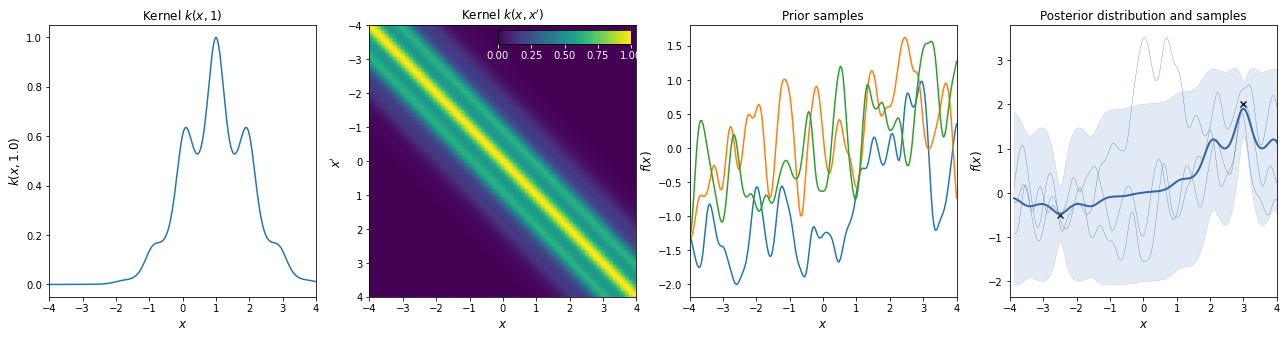

In [16]:
k = GPy.kern.StdPeriodic(1) * GPy.kern.RBF(1)
plot_kernel(k)

### Linear + Exponential

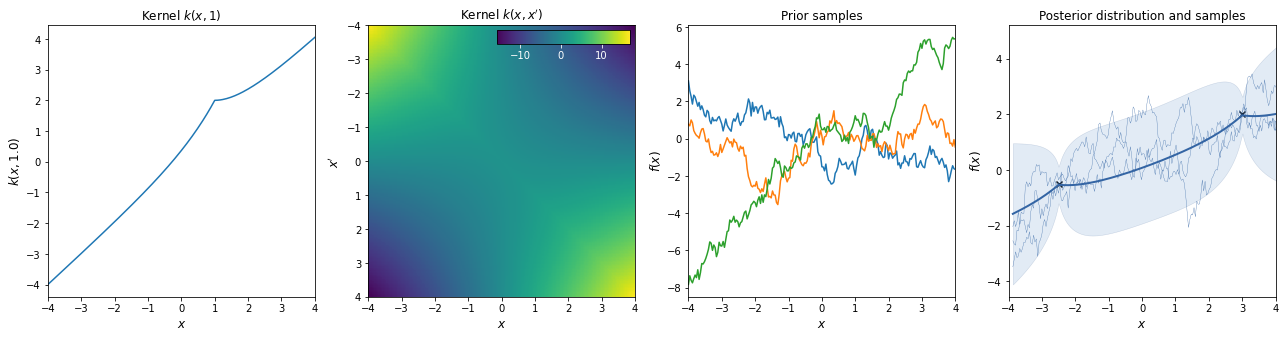

In [17]:
k = GPy.kern.Linear(1) + GPy.kern.Exponential(1)
plot_kernel(k)

### Liner + Periodic

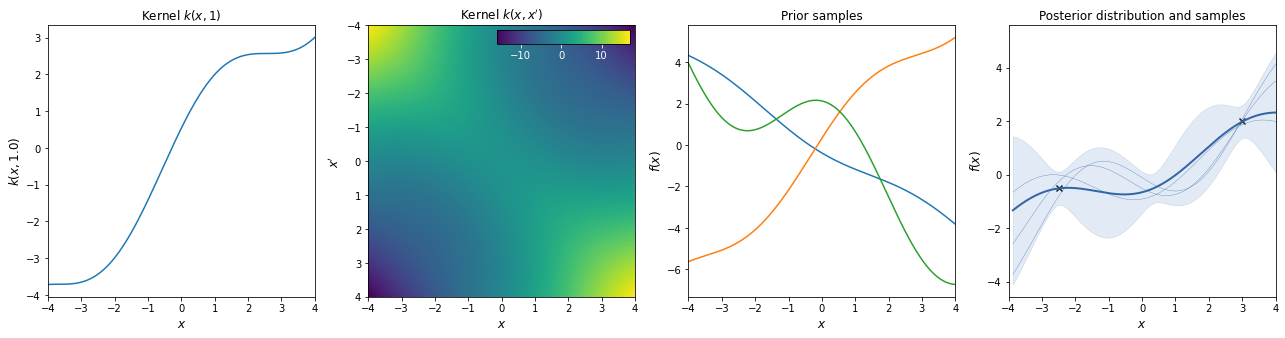

In [18]:
k = GPy.kern.Linear(1) + GPy.kern.Cosine(1)
plot_kernel(k)

### Linear * Periodic
The linear kernel increases the amplitude of the periodic function as we move away from $x=0$.

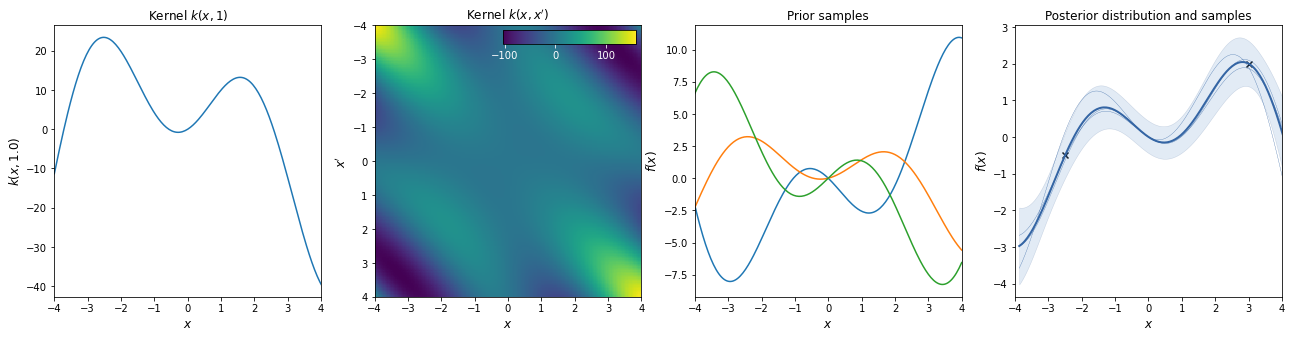

In [19]:
k = GPy.kern.Linear(1, variances=10) * GPy.kern.Cosine(1)
plot_kernel(k)